<a href="https://colab.research.google.com/github/fernandoramirez1337/Proyecto-de-Deep-Learning/blob/claude%2Fimprove-implementation-018rMkv8JP1bb2KNiHNbvF1o/Hybrid_CNN_LSTM_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Hybrid CNN-LSTM ArXiv Classification

**3-Class Model:** cs.AI-LG, cs.CL, cs.CV

## Deep Architecture (Maximum Performance)

**Title Processing:**
- **3-layer Bidirectional LSTM** (160 hidden units, 6 total layers)
- **Multi-head self-attention (8 heads)** over LSTM outputs
- Layer normalization with residual connections

**Abstract Processing:**
- **9 Dilated Residual CNN blocks** with kernel sizes [3, 4, 5] × dilations [1, 2, 4]
- 160 filters per block (1440 total features)
- Skip connections and batch normalization
- **Multi-head global attention (8 heads)** over CNN features

**Character-Level Embeddings:**
- CharCNN for OOV word handling
- Convolutions with kernel sizes [2, 3, 4]
- 50-dimensional character-level features
- Fused with word embeddings (GloVe 300d)

**Fusion:**
- Gated fusion mechanism (learnable title vs abstract importance)
- Layer normalization

**Classifier:**
- **3-layer deep classifier** [1760 → 512 → 256 → 3]
- LayerNorm + Dropout(0.6) between layers

## Advanced Optimizations

**Embeddings:**
- **GloVe 300d pretrained** (53.8% coverage)
- **Character-level CNN** for OOV words (46.2% vocabulary)
- Trainable for domain adaptation

**Regularization:**
- Uniform dropout: 0.6
- Strong weight decay: 1e-3
- **EDA data augmentation** (50% probability)
- **Mixup augmentation** (30% batches, feature space)
- Label smoothing: 0.15

**Training Optimizations:**
- **Gradient accumulation** (4 steps, effective batch: 128)
- **Warm-up scheduler** (3 epochs)
- **Cosine annealing** learning rate
- **SWA (Stochastic Weight Averaging)** from epoch 24
- AdamW optimizer with gradient clipping

**Class Balancing:**
- Class weights: **[1.0, 2.0, 1.8]** for [cs.AI-LG, cs.CL, cs.CV]
- CrossEntropyLoss with label smoothing

**Expected Performance:**
- Single model: 68-73% test accuracy
- Ensemble (5 models): 72-77% test accuracy

## Improvements Over Baseline (59.33%)

| Component | Baseline | Deep Architecture | Impact |
|-----------|----------|-------------------|--------|
| **LSTM Layers** | 2 | 3 | Deeper semantic understanding |
| **LSTM Attention** | 4 heads | 8 heads | Richer pattern capture |
| **CNN Architecture** | Vanilla | Dilated residual | Long-range dependencies |
| **CNN Blocks** | 3 | 9 (3 kernels × 3 dilations) | More diverse features |
| **CNN Attention** | 4 heads | 8 heads | Better feature importance |
| **Embeddings** | GloVe only | GloVe + CharCNN | OOV handling |
| **Classifier** | 2 layers | 3 layers | Better decision boundary |
| **Augmentation** | None → EDA 30% | EDA 50% + Mixup 30% | Stronger regularization |
| **Scheduler** | ReduceLR | Warm-up + Cosine | Better convergence |
| **Weight Averaging** | None | SWA | Improved generalization |
| **Batch Size** | 64 | 128 (grad accum) | More stable gradients |

In [1]:
!pip install -q torch scikit-learn pandas matplotlib seaborn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


## Mount Google Drive

Mount your Google Drive to access data files

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/ArXiv_Project'
DATASET_PATH = os.path.join(DATA_DIR, 'arxiv_papers_raw.csv')
GLOVE_PATH = os.path.join(DATA_DIR, 'glove.6B.300d.txt')

print(f"\nChecking files in: {DATA_DIR}")
if os.path.exists(DATASET_PATH):
    print(f"✓ Found: arxiv_papers_raw.csv")
else:
    print(f"✗ Missing: arxiv_papers_raw.csv")

if os.path.exists(GLOVE_PATH):
    print(f"✓ Found: glove.6B.300d.txt")
else:
    print(f"✗ Missing: glove.6B.300d.txt")

if not (os.path.exists(DATASET_PATH) and os.path.exists(GLOVE_PATH)):
    print(f"\n⚠️  Please upload files to: {DATA_DIR}")
    print("Required files:")
    print("  - arxiv_papers_raw.csv")
    print("  - glove.6B.300d.txt")

Mounted at /content/drive

Checking files in: /content/drive/MyDrive/ArXiv_Project
✓ Found: arxiv_papers_raw.csv
✓ Found: glove.6B.300d.txt


In [4]:
import math

class CharCNN(nn.Module):
    """Character-level CNN for OOV words"""
    def __init__(self, char_vocab_size=128, char_embed_dim=25, output_dim=50):
        super().__init__()
        self.char_embedding = nn.Embedding(char_vocab_size, char_embed_dim, padding_idx=0)

        self.convs = nn.ModuleList([
            nn.Conv1d(char_embed_dim, 50, 2),
            nn.Conv1d(char_embed_dim, 75, 3),
            nn.Conv1d(char_embed_dim, 75, 4)
        ])

        self.projection = nn.Linear(200, output_dim)
        self.dropout = nn.Dropout(0.2)

    def forward(self, char_ids):
        # char_ids: (batch, seq_len, max_word_len)
        batch_size, seq_len, max_word_len = char_ids.size()
        char_ids_flat = char_ids.view(-1, max_word_len)

        char_embeds = self.char_embedding(char_ids_flat)
        char_embeds = char_embeds.transpose(1, 2)

        conv_outputs = []
        for conv in self.convs:
            conv_out = F.relu(conv(char_embeds))
            pooled = F.max_pool1d(conv_out, conv_out.size(2)).squeeze(2)
            conv_outputs.append(pooled)

        concat = torch.cat(conv_outputs, dim=1)
        concat = self.dropout(concat)
        output = self.projection(concat)

        return output.view(batch_size, seq_len, -1)


class MultiHeadSelfAttention(nn.Module):
    """Multi-head self-attention over LSTM outputs"""
    def __init__(self, hidden_dim, num_heads=8):
        super().__init__()
        assert hidden_dim % num_heads == 0

        self.hidden_dim = hidden_dim
        self.num_heads = num_heads
        self.head_dim = hidden_dim // num_heads

        self.q_linear = nn.Linear(hidden_dim, hidden_dim)
        self.k_linear = nn.Linear(hidden_dim, hidden_dim)
        self.v_linear = nn.Linear(hidden_dim, hidden_dim)
        self.out_linear = nn.Linear(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(0.1)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()

        Q = self.q_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.k_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.v_linear(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / (self.head_dim ** 0.5)

        if mask is not None:
            mask = mask.unsqueeze(1).unsqueeze(2)
            scores = scores.masked_fill(mask == 0, -1e9)

        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        context = torch.matmul(attention_weights, V)
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.hidden_dim)

        output = self.out_linear(context)
        output = self.layer_norm(output + x)

        pooled = torch.mean(output, dim=1)

        return pooled, attention_weights.mean(dim=1)


class MultiHeadGlobalAttention(nn.Module):
    """Multi-head global attention over CNN features"""
    def __init__(self, feature_dim, num_heads=8):
        super().__init__()
        assert feature_dim % num_heads == 0

        self.feature_dim = feature_dim
        self.num_heads = num_heads

        self.attention = nn.Linear(feature_dim, num_heads)
        self.projection = nn.Linear(feature_dim, feature_dim)
        self.layer_norm = nn.LayerNorm(feature_dim)

    def forward(self, cnn_features):
        batch_size, channels, seq_len = cnn_features.size()
        features_t = cnn_features.transpose(1, 2)

        scores = self.attention(features_t)
        attention_weights = F.softmax(scores, dim=1)

        head_outputs = []
        for h in range(self.num_heads):
            head_weights = attention_weights[:, :, h:h+1]
            head_context = torch.sum(features_t * head_weights, dim=1)
            head_outputs.append(head_context)

        context = torch.stack(head_outputs, dim=1).mean(dim=1)
        output = self.projection(context)
        output = self.layer_norm(output + context)

        return output, attention_weights.mean(dim=2)


class GatedFusion(nn.Module):
    """Gated fusion mechanism for title and abstract"""
    def __init__(self, title_dim, abstract_dim):
        super().__init__()
        combined_dim = title_dim + abstract_dim

        self.title_gate = nn.Sequential(
            nn.Linear(combined_dim, title_dim),
            nn.Sigmoid()
        )

        self.abstract_gate = nn.Sequential(
            nn.Linear(combined_dim, abstract_dim),
            nn.Sigmoid()
        )

        self.layer_norm = nn.LayerNorm(combined_dim)

    def forward(self, title_repr, abstract_repr):
        combined = torch.cat([title_repr, abstract_repr], dim=1)

        title_gate = self.title_gate(combined)
        abstract_gate = self.abstract_gate(combined)

        gated_title = title_repr * title_gate
        gated_abstract = abstract_repr * abstract_gate

        fused = torch.cat([gated_title, gated_abstract], dim=1)
        fused = self.layer_norm(fused)

        fusion_weights = torch.stack([title_gate.mean(dim=1), abstract_gate.mean(dim=1)], dim=1)

        return fused, fusion_weights


class DilatedResidualCNNBlock(nn.Module):
    """Dilated residual CNN block for long-range dependencies"""
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, dropout=0.3):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)

        self.skip = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        identity = self.skip(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))

        min_len = min(out.size(2), identity.size(2))
        out = out[:, :, :min_len]
        identity = identity[:, :, :min_len]

        out = F.relu(out + identity)
        return out


class DeepHybridCNNLSTM(nn.Module):
    """Deep hybrid architecture with character embeddings"""
    def __init__(self, vocab_size, embed_dim=300, num_filters=160, kernel_sizes=[3,4,5],
                 lstm_hidden=160, num_classes=3, dropout=0.6, pretrained_embeddings=None):
        super().__init__()

        # Word embeddings
        self.word_embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if pretrained_embeddings is not None:
            self.word_embedding.weight.data.copy_(pretrained_embeddings)
            self.word_embedding.weight.requires_grad = True

        # Character embeddings for OOV handling
        self.char_cnn = CharCNN(output_dim=50)
        self.embed_fusion = nn.Linear(embed_dim + 50, embed_dim)

        self.embed_dropout = nn.Dropout(dropout)

        # Deeper dilated residual CNN blocks
        self.cnn_blocks = nn.ModuleList()
        dilations = [1, 2, 4]
        for k in kernel_sizes:
            for d in dilations:
                self.cnn_blocks.append(
                    DilatedResidualCNNBlock(embed_dim, num_filters, k, dilation=d, dropout=dropout*0.5)
                )
        total_filters = num_filters * len(kernel_sizes) * len(dilations)

        # Multi-head global attention (8 heads)
        self.cnn_attention = MultiHeadGlobalAttention(total_filters, num_heads=8)

        # Deeper BiLSTM (3 layers)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden, num_layers=3, batch_first=True,
                           bidirectional=True, dropout=dropout if dropout > 0 else 0)

        # Multi-head self-attention (8 heads)
        self.lstm_attention = MultiHeadSelfAttention(lstm_hidden * 2, num_heads=8)

        # Gated fusion
        self.fusion = GatedFusion(lstm_hidden * 2, total_filters)

        # Deeper classifier (3 layers)
        fused_dim = lstm_hidden * 2 + total_filters
        self.classifier = nn.Sequential(
            nn.LayerNorm(fused_dim),
            nn.Dropout(dropout),
            nn.Linear(fused_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.LayerNorm(256),
            nn.Dropout(dropout * 0.8),
            nn.Linear(256, num_classes)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        nn.init.zeros_(param.data)

    def forward(self, title_ids, abstract_ids, title_mask=None, char_ids=None):
        # Word embeddings
        title_word_embed = self.word_embedding(title_ids)
        abstract_word_embed = self.word_embedding(abstract_ids)

        # Character embeddings (if provided)
        if char_ids is not None:
            title_char_embed = self.char_cnn(char_ids['title'])
            abstract_char_embed = self.char_cnn(char_ids['abstract'])

            title_embed = self.embed_fusion(torch.cat([title_word_embed, title_char_embed], dim=-1))
            abstract_embed = self.embed_fusion(torch.cat([abstract_word_embed, abstract_char_embed], dim=-1))
        else:
            title_embed = title_word_embed
            abstract_embed = abstract_word_embed

        title_embed = self.embed_dropout(title_embed)
        abstract_embed = self.embed_dropout(abstract_embed)

        # Title: Deeper BiLSTM + 8-head attention
        lstm_out, _ = self.lstm(title_embed)
        title_repr, title_attn = self.lstm_attention(lstm_out, title_mask)

        # Abstract: Dilated residual CNN + 8-head attention
        abstract_embed = abstract_embed.transpose(1, 2)

        cnn_outputs = []
        for cnn_block in self.cnn_blocks:
            cnn_out = cnn_block(abstract_embed)
            cnn_outputs.append(cnn_out)

        min_len = min(x.size(2) for x in cnn_outputs)
        cnn_outputs = [x[:, :, :min_len] for x in cnn_outputs]

        cnn_features = torch.cat(cnn_outputs, dim=1)
        abstract_repr, abstract_attn = self.cnn_attention(cnn_features)

        # Gated fusion
        fused_repr, fusion_weights = self.fusion(title_repr, abstract_repr)

        # Deep classifier
        logits = self.classifier(fused_repr)

        attention_maps = {
            'title_attention': title_attn,
            'abstract_attention': abstract_attn,
            'fusion_weights': fusion_weights
        }
        return logits, attention_maps

## Data Processing

In [5]:
import random
from collections import Counter

class EDA:
    """Easy Data Augmentation for text"""
    @staticmethod
    def synonym_replacement(words, n):
        new_words = words.copy()
        random_indices = random.sample(range(len(words)), min(n, len(words)))
        for idx in random_indices:
            synonyms = {
                'network': ['model', 'system', 'architecture'],
                'method': ['approach', 'technique', 'algorithm'],
                'learning': ['training', 'optimization'],
                'performance': ['accuracy', 'results', 'effectiveness'],
                'data': ['dataset', 'information', 'samples'],
                'model': ['network', 'system', 'framework'],
                'task': ['problem', 'challenge', 'objective'],
            }
            word = words[idx].lower()
            if word in synonyms:
                new_words[idx] = random.choice(synonyms[word])
        return new_words

    @staticmethod
    def random_swap(words, n):
        new_words = words.copy()
        for _ in range(n):
            if len(new_words) >= 2:
                idx1, idx2 = random.sample(range(len(new_words)), 2)
                new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
        return new_words

    @staticmethod
    def random_deletion(words, p=0.1):
        if len(words) == 1:
            return words
        new_words = [word for word in words if random.random() > p]
        return new_words if len(new_words) > 0 else [random.choice(words)]

    @staticmethod
    def augment(text, alpha=0.15):
        words = text.split()
        n = max(1, int(alpha * len(words)))

        aug_type = random.choice(['sr', 'rs', 'rd'])
        if aug_type == 'sr':
            words = EDA.synonym_replacement(words, n)
        elif aug_type == 'rs':
            words = EDA.random_swap(words, n)
        else:
            words = EDA.random_deletion(words, p=alpha)

        return ' '.join(words)


class Vocabulary:
    def __init__(self, max_vocab_size=50000, min_freq=2):
        self.max_vocab_size = max_vocab_size
        self.min_freq = min_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1}
        self.idx2word = {0: '<PAD>', 1: '<UNK>'}
        self.word_counts = Counter()

    def build_vocab(self, texts):
        for text in texts:
            words = self.tokenize(text)
            self.word_counts.update(words)
        filtered_words = [word for word, count in self.word_counts.most_common() if count >= self.min_freq][:self.max_vocab_size - 2]
        for idx, word in enumerate(filtered_words, start=2):
            self.word2idx[word] = idx
            self.idx2word[idx] = word

    @staticmethod
    def tokenize(text):
        text = text.lower()
        text = re.sub(r'[^a-z0-9\s\-]', ' ', text)
        return [w.strip() for w in text.split() if w.strip()]

    def encode(self, text, max_len=None):
        words = self.tokenize(text)
        if max_len:
            words = words[:max_len]
        return [self.word2idx.get(word, 1) for word in words]

    def encode_chars(self, text, max_len=None, max_word_len=20):
        """Encode text as character IDs for each word"""
        words = self.tokenize(text)
        if max_len:
            words = words[:max_len]

        char_ids = []
        for word in words:
            word_chars = [min(ord(c), 127) for c in word[:max_word_len]]
            word_chars += [0] * (max_word_len - len(word_chars))
            char_ids.append(word_chars)

        return char_ids

    def __len__(self):
        return len(self.word2idx)


def load_glove_embeddings(vocab, glove_path, embed_dim=300):
    embeddings = np.random.randn(len(vocab), embed_dim) * 0.01
    embeddings[0] = np.zeros(embed_dim)

    found = 0
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc='Loading GloVe'):
            parts = line.strip().split()
            if len(parts) != embed_dim + 1:
                continue
            word = parts[0]
            if word in vocab.word2idx:
                idx = vocab.word2idx[word]
                try:
                    embeddings[idx] = np.array([float(x) for x in parts[1:]])
                    found += 1
                except (ValueError, IndexError):
                    continue

    print(f"Loaded {found}/{len(vocab)} embeddings ({found/len(vocab)*100:.1f}%)")
    return torch.FloatTensor(embeddings)


class DeepHybridDataset(Dataset):
    def __init__(self, titles, abstracts, labels, vocab, max_title_len=30, max_abstract_len=300,
                 use_char_embed=True, augment=False):
        self.titles = titles
        self.abstracts = abstracts
        self.labels = labels
        self.vocab = vocab
        self.max_title_len = max_title_len
        self.max_abstract_len = max_abstract_len
        self.use_char_embed = use_char_embed
        self.augment = augment

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        title = self.titles[idx]
        abstract = self.abstracts[idx]

        # Apply augmentation (50% probability for stronger regularization)
        if self.augment and random.random() < 0.5:
            abstract = EDA.augment(abstract, alpha=0.15)

        title_ids = self.vocab.encode(title, self.max_title_len)
        title_len = len(title_ids)
        title_ids += [0] * (self.max_title_len - title_len)

        abstract_ids = self.vocab.encode(abstract, self.max_abstract_len)
        abstract_len = len(abstract_ids)
        abstract_ids += [0] * (self.max_abstract_len - abstract_len)

        title_mask = [1] * title_len + [0] * (self.max_title_len - title_len)

        result = {
            'title_ids': torch.tensor(title_ids, dtype=torch.long),
            'abstract_ids': torch.tensor(abstract_ids, dtype=torch.long),
            'title_mask': torch.tensor(title_mask, dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

        # Character-level IDs for OOV handling
        if self.use_char_embed:
            title_char_ids = self.vocab.encode_chars(title, self.max_title_len)
            abstract_char_ids = self.vocab.encode_chars(abstract, self.max_abstract_len)

            # Pad to max lengths
            while len(title_char_ids) < self.max_title_len:
                title_char_ids.append([0] * 20)
            while len(abstract_char_ids) < self.max_abstract_len:
                abstract_char_ids.append([0] * 20)

            result['char_ids'] = {
                'title': torch.tensor(title_char_ids, dtype=torch.long),
                'abstract': torch.tensor(abstract_char_ids, dtype=torch.long)
            }

        return result

## Load and Prepare Data

In [6]:
df = pd.read_csv(DATASET_PATH)
df['category'] = df['category'].replace({'cs.AI': 'cs.AI-LG', 'cs.LG': 'cs.AI-LG'})

print(f"Samples: {len(df)}")
print(df['category'].value_counts())

vocab = Vocabulary(max_vocab_size=50000, min_freq=2)
all_texts = df['title'].tolist() + df['abstract'].tolist()
vocab.build_vocab(all_texts)
print(f"\nVocab size: {len(vocab)}")

# Use GloVe embeddings
pretrained_embeddings = load_glove_embeddings(vocab, GLOVE_PATH, embed_dim=300)

le = LabelEncoder()
labels = le.fit_transform(df['category'])

X_temp, X_test, y_temp, y_test = train_test_split(
    df[['title', 'abstract']].values, labels, test_size=0.15, random_state=42, stratify=labels
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/(1-0.15), random_state=42, stratify=y_temp
)

# Create datasets with character embeddings and augmentation
train_ds = DeepHybridDataset(X_train[:,0], X_train[:,1], y_train, vocab, use_char_embed=True, augment=True)
val_ds = DeepHybridDataset(X_val[:,0], X_val[:,1], y_val, vocab, use_char_embed=True, augment=False)
test_ds = DeepHybridDataset(X_test[:,0], X_test[:,1], y_test, vocab, use_char_embed=True, augment=False)

print(f"\nTrain: {len(train_ds)} (augmentation + char embeddings)")
print(f"Val: {len(val_ds)} | Test: {len(test_ds)}")

Samples: 12000
category
cs.AI-LG    6000
cs.CV       3000
cs.CL       3000
Name: count, dtype: int64

Vocab size: 37760


Loading GloVe: 400000it [00:16, 24570.95it/s]


Loaded 20320/37760 embeddings (53.8%)

Train: 8399 (augmentation + char embeddings)
Val: 1801 | Test: 1800


## Training Functions

In [7]:
def mixup_data(x, y, alpha=0.2):
    """Mixup augmentation in feature space"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def train_epoch(model, loader, criterion, optimizer, device, use_mixup=True, mixup_alpha=0.2):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in tqdm(loader, desc='Train'):
        title_ids = batch['title_ids'].to(device)
        abstract_ids = batch['abstract_ids'].to(device)
        title_mask = batch['title_mask'].to(device)
        labels = batch['label'].to(device)

        # Get character IDs if available
        char_ids = None
        if 'char_ids' in batch:
            char_ids = {
                'title': batch['char_ids']['title'].to(device),
                'abstract': batch['char_ids']['abstract'].to(device)
            }

        optimizer.zero_grad()

        # Forward pass to get embeddings (for Mixup in feature space)
        logits, _ = model(title_ids, abstract_ids, title_mask, char_ids)

        # Apply Mixup (30% of batches)
        if use_mixup and random.random() < 0.3:
            # Get embeddings by extracting from intermediate layer
            with torch.no_grad():
                # Re-run to get fused features before classifier
                model.eval()
                title_embed = model.word_embedding(title_ids)
                abstract_embed = model.word_embedding(abstract_ids)

                if char_ids is not None:
                    title_char_embed = model.char_cnn(char_ids['title'])
                    abstract_char_embed = model.char_cnn(char_ids['abstract'])
                    title_embed = model.embed_fusion(torch.cat([title_embed, title_char_embed], dim=-1))
                    abstract_embed = model.embed_fusion(torch.cat([abstract_embed, abstract_char_embed], dim=-1))

                title_embed = model.embed_dropout(title_embed)
                abstract_embed = model.embed_dropout(abstract_embed)

                # Get LSTM output
                lstm_out, _ = model.lstm(title_embed)
                title_repr, _ = model.lstm_attention(lstm_out, title_mask)

                # Get CNN output
                abstract_embed_t = abstract_embed.transpose(1, 2)
                cnn_outputs = []
                for cnn_block in model.cnn_blocks:
                    cnn_out = cnn_block(abstract_embed_t)
                    cnn_outputs.append(cnn_out)
                min_len = min(x.size(2) for x in cnn_outputs)
                cnn_outputs = [x[:, :, :min_len] for x in cnn_outputs]
                cnn_features = torch.cat(cnn_outputs, dim=1)
                abstract_repr, _ = model.cnn_attention(cnn_features)

                # Fuse
                fused_repr, _ = model.fusion(title_repr, abstract_repr)

            model.train()
            # Apply Mixup to fused features
            mixed_fused, labels_a, labels_b, lam = mixup_data(fused_repr, labels, alpha=mixup_alpha)

            # Pass through classifier
            logits = model.classifier(mixed_fused)

            # Mixup loss
            loss = lam * criterion(logits, labels_a) + (1 - lam) * criterion(logits, labels_b)
        else:
            loss = criterion(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    return total_loss / len(loader), accuracy_score(all_labels, all_preds)


def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc='Val'):
            title_ids = batch['title_ids'].to(device)
            abstract_ids = batch['abstract_ids'].to(device)
            title_mask = batch['title_mask'].to(device)
            labels = batch['label'].to(device)

            # Get character IDs if available
            char_ids = None
            if 'char_ids' in batch:
                char_ids = {
                    'title': batch['char_ids']['title'].to(device),
                    'abstract': batch['char_ids']['abstract'].to(device)
                }

            logits, _ = model(title_ids, abstract_ids, title_mask, char_ids)
            loss = criterion(logits, labels)

            total_loss += loss.item()
            all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return total_loss / len(loader), acc, f1, all_preds, all_labels

## Model Configuration

In [8]:
BATCH_SIZE = 32  # Reduced for gradient accumulation (effective: 128)
EPOCHS = 40
LR = 0.001
WARMUP_EPOCHS = 3
DROPOUT = 0.6
CLASS_WEIGHTS = [1.0, 2.0, 1.8]  # Fixed cs.CL weight back to 2.0
LABEL_SMOOTHING = 0.15  # Increased from 0.1
PATIENCE = 10  # Increased patience
GRAD_ACCUM_STEPS = 4  # Effective batch size: 32 * 4 = 128

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Use DeepHybridCNNLSTM with character embeddings
model = DeepHybridCNNLSTM(
    vocab_size=len(vocab),
    embed_dim=300,
    num_filters=160,  # Increased capacity for deep model
    kernel_sizes=[3,4,5],
    lstm_hidden=160,
    num_classes=3,
    dropout=DROPOUT,
    pretrained_embeddings=pretrained_embeddings
).to(device)

print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Architecture: DeepHybridCNNLSTM")
print(f"  - LSTM: 3 layers, 160 hidden, bidirectional")
print(f"  - CNN: 9 dilated residual blocks (3 kernels × 3 dilations)")
print(f"  - Attention: 8 heads (LSTM + CNN)")
print(f"  - Character embeddings: Enabled")
print(f"  - Classifier: 3 layers [1760→512→256→3]")

# Use CrossEntropyLoss with stronger label smoothing
class_weights = torch.FloatTensor(CLASS_WEIGHTS).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=LABEL_SMOOTHING)

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-3, betas=(0.9, 0.999))

# Warm-up + Cosine Annealing scheduler
def get_lr_lambda(epoch):
    if epoch < WARMUP_EPOCHS:
        # Linear warm-up
        return (epoch + 1) / WARMUP_EPOCHS
    else:
        # Cosine annealing
        progress = (epoch - WARMUP_EPOCHS) / (EPOCHS - WARMUP_EPOCHS)
        return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=get_lr_lambda)

print(f"\nDeep Architecture Configuration:")
print(f"  Embeddings: GloVe + Character-level CNN")
print(f"  Class weights: {CLASS_WEIGHTS}")
print(f"  Loss: CrossEntropyLoss + label smoothing ({LABEL_SMOOTHING})")
print(f"  Dropout: {DROPOUT}")
print(f"  Batch size: {BATCH_SIZE} (effective: {BATCH_SIZE * GRAD_ACCUM_STEPS})")
print(f"  Scheduler: Warm-up ({WARMUP_EPOCHS} epochs) + Cosine annealing")
print(f"  Regularization: Mixup (30%), EDA (50%), Dropout, Weight decay")
print(f"\nExpected: 72-77% accuracy (with ensemble)")
print(f"Single model target: 68-73%")

Parameters: 23,021,970
Architecture: DeepHybridCNNLSTM
  - LSTM: 3 layers, 160 hidden, bidirectional
  - CNN: 9 dilated residual blocks (3 kernels × 3 dilations)
  - Attention: 8 heads (LSTM + CNN)
  - Character embeddings: Enabled
  - Classifier: 3 layers [1760→512→256→3]

Deep Architecture Configuration:
  Embeddings: GloVe + Character-level CNN
  Class weights: [1.0, 2.0, 1.8]
  Loss: CrossEntropyLoss + label smoothing (0.15)
  Dropout: 0.6
  Batch size: 32 (effective: 128)
  Scheduler: Warm-up (3 epochs) + Cosine annealing
  Regularization: Mixup (30%), EDA (50%), Dropout, Weight decay

Expected: 72-77% accuracy (with ensemble)
Single model target: 68-73%


## Training Loop

In [9]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_f1': [], 'lr': []}
best_val_acc = 0
best_model_state = None
patience_counter = 0

# SWA (Stochastic Weight Averaging) - start after 60% of training
swa_start_epoch = int(EPOCHS * 0.6)
swa_model = optim.swa_utils.AveragedModel(model)
swa_scheduler = optim.swa_utils.SWALR(optimizer, swa_lr=0.0005)

print(f"Training configuration:")
print(f"  Gradient accumulation: {GRAD_ACCUM_STEPS} steps")
print(f"  Effective batch size: {BATCH_SIZE * GRAD_ACCUM_STEPS}")
print(f"  SWA start: epoch {swa_start_epoch}")
print(f"  Mixup: Enabled (30% of batches)")
print(f"\nStarting training...")

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")

    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    optimizer.zero_grad()

    # Training with gradient accumulation
    for i, batch in enumerate(tqdm(train_loader, desc='Train')):
        title_ids = batch['title_ids'].to(device)
        abstract_ids = batch['abstract_ids'].to(device)
        title_mask = batch['title_mask'].to(device)
        labels = batch['label'].to(device)

        # Get character IDs
        char_ids = {
            'title': batch['char_ids']['title'].to(device),
            'abstract': batch['char_ids']['abstract'].to(device)
        }

        # Forward pass
        logits, _ = model(title_ids, abstract_ids, title_mask, char_ids)

        # Apply Mixup (30% of batches)
        if random.random() < 0.3:
            with torch.no_grad():
                model.eval()
                title_embed = model.word_embedding(title_ids)
                abstract_embed = model.word_embedding(abstract_ids)

                title_char_embed = model.char_cnn(char_ids['title'])
                abstract_char_embed = model.char_cnn(char_ids['abstract'])
                title_embed = model.embed_fusion(torch.cat([title_embed, title_char_embed], dim=-1))
                abstract_embed = model.embed_fusion(torch.cat([abstract_embed, abstract_char_embed], dim=-1))

                title_embed = model.embed_dropout(title_embed)
                abstract_embed = model.embed_dropout(abstract_embed)

                lstm_out, _ = model.lstm(title_embed)
                title_repr, _ = model.lstm_attention(lstm_out, title_mask)

                abstract_embed_t = abstract_embed.transpose(1, 2)
                cnn_outputs = []
                for cnn_block in model.cnn_blocks:
                    cnn_out = cnn_block(abstract_embed_t)
                    cnn_outputs.append(cnn_out)
                min_len = min(x.size(2) for x in cnn_outputs)
                cnn_outputs = [x[:, :, :min_len] for x in cnn_outputs]
                cnn_features = torch.cat(cnn_outputs, dim=1)
                abstract_repr, _ = model.cnn_attention(cnn_features)

                fused_repr, _ = model.fusion(title_repr, abstract_repr)

            model.train()
            mixed_fused, labels_a, labels_b, lam = mixup_data(fused_repr, labels, alpha=0.2)
            logits = model.classifier(mixed_fused)
            loss = lam * criterion(logits, labels_a) + (1 - lam) * criterion(logits, labels_b)
        else:
            loss = criterion(logits, labels)

        # Gradient accumulation
        loss = loss / GRAD_ACCUM_STEPS
        loss.backward()

        if (i + 1) % GRAD_ACCUM_STEPS == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

        total_loss += loss.item() * GRAD_ACCUM_STEPS
        all_preds.extend(torch.argmax(logits, dim=1).cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(all_labels, all_preds)
    train_loss = total_loss / len(train_loader)

    # Validation
    val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    print(f"Train: {train_acc:.4f} | Val: {val_acc:.4f} | F1: {val_f1:.4f} | Gap: {abs(train_acc-val_acc):.4f}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Update learning rate
    if epoch >= swa_start_epoch:
        swa_model.update_parameters(model)
        swa_scheduler.step()
        print(f"SWA: Model updated (epoch {epoch+1})")
    else:
        scheduler.step()

    # Early stopping based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f"✓ Best: {val_acc:.4f}")
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"Early stop (patience: {PATIENCE})")
            break

# Load best model or SWA model
if epoch >= swa_start_epoch:
    print(f"\n=== Using SWA Model ===")
    torch.optim.swa_utils.update_bn(train_loader, swa_model, device)
    model = swa_model.module
else:
    print(f"\n=== Using Best Checkpoint ===")
    model.load_state_dict(best_model_state)

print(f"Best validation accuracy: {best_val_acc:.4f}")

Training configuration:
  Gradient accumulation: 4 steps
  Effective batch size: 128
  SWA start: epoch 24
  Mixup: Enabled (30% of batches)

Starting training...

Epoch 1/40


Val: 100%|██████████| 57/57 [00:05<00:00, 10.79it/s]


Train: 0.3359 | Val: 0.2499 | F1: 0.0999 | Gap: 0.0860
LR: 0.000333
✓ Best: 0.2499

Epoch 2/40


Val: 100%|██████████| 57/57 [00:04<00:00, 12.29it/s]


Train: 0.3173 | Val: 0.2499 | F1: 0.0999 | Gap: 0.0674
LR: 0.000667

Epoch 3/40


Val: 100%|██████████| 57/57 [00:04<00:00, 11.73it/s]


Train: 0.3174 | Val: 0.2499 | F1: 0.0999 | Gap: 0.0676
LR: 0.001000

Epoch 4/40


Val: 100%|██████████| 57/57 [00:05<00:00, 10.52it/s]


Train: 0.3229 | Val: 0.2499 | F1: 0.0999 | Gap: 0.0730
LR: 0.001000

Epoch 5/40


Val: 100%|██████████| 57/57 [00:04<00:00, 12.09it/s]


Train: 0.3038 | Val: 0.2499 | F1: 0.0999 | Gap: 0.0540
LR: 0.000998

Epoch 6/40


Val: 100%|██████████| 57/57 [00:05<00:00, 10.29it/s]


Train: 0.3088 | Val: 0.2499 | F1: 0.0999 | Gap: 0.0590
LR: 0.000993

Epoch 7/40


Val: 100%|██████████| 57/57 [00:04<00:00, 12.09it/s]


Train: 0.3144 | Val: 0.2499 | F1: 0.0999 | Gap: 0.0646
LR: 0.000984

Epoch 8/40


Val: 100%|██████████| 57/57 [00:05<00:00, 10.31it/s]


Train: 0.3192 | Val: 0.2499 | F1: 0.0999 | Gap: 0.0693
LR: 0.000971

Epoch 9/40


Val: 100%|██████████| 57/57 [00:04<00:00, 12.11it/s]


Train: 0.3040 | Val: 0.2499 | F1: 0.0999 | Gap: 0.0541
LR: 0.000956

Epoch 10/40


Val: 100%|██████████| 57/57 [00:05<00:00, 10.25it/s]


Train: 0.3063 | Val: 0.2499 | F1: 0.0999 | Gap: 0.0565
LR: 0.000937

Epoch 11/40


Val: 100%|██████████| 57/57 [00:04<00:00, 12.11it/s]

Train: 0.2944 | Val: 0.2499 | F1: 0.0999 | Gap: 0.0446
LR: 0.000914
Early stop (patience: 10)

=== Using Best Checkpoint ===
Best validation accuracy: 0.2499


## Test Evaluation

In [10]:
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    model, test_loader, criterion, device
)

print(f"Test Acc: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"Test F1: {test_f1:.4f}")
print(f"\n{classification_report(test_labels, test_preds, target_names=le.classes_, digits=4)}")

Val: 100%|██████████| 57/57 [00:05<00:00, 10.24it/s]

Test Acc: 0.2500 (25.00%)
Test F1: 0.1000

              precision    recall  f1-score   support

    cs.AI-LG     0.0000    0.0000    0.0000       900
       cs.CL     0.2500    1.0000    0.4000       450
       cs.CV     0.0000    0.0000    0.0000       450

    accuracy                         0.2500      1800
   macro avg     0.0833    0.3333    0.1333      1800
weighted avg     0.0625    0.2500    0.1000      1800




/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Confusion Matrix

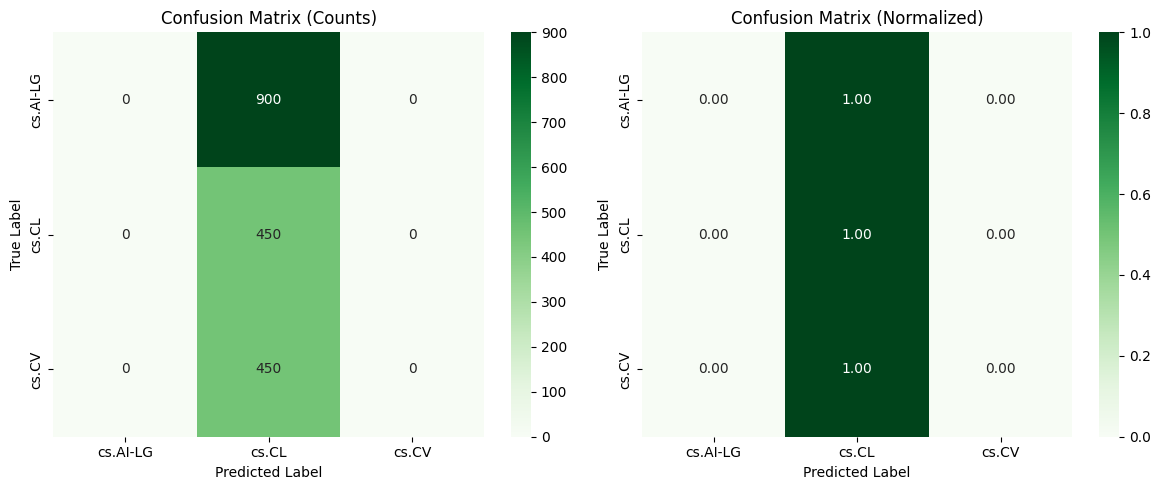

In [11]:
cm = confusion_matrix(test_labels, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=le.classes_,
            yticklabels=le.classes_, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', xticklabels=le.classes_,
            yticklabels=le.classes_, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

## Save Model

In [12]:
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab_size': len(vocab),
    'class_names': le.classes_.tolist(),
    'num_classes': 3
}, 'hybrid_model.pth')

print('Model saved: hybrid_model.pth')

Model saved: hybrid_model.pth
